# ZOO faster than FOO

## Prepare

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data

import torch.nn.utils.prune as prune

import numpy as np
import math
import os
import time
import matplotlib.pyplot as plt

from import_shelf import shelf
from shelf.models.transformer import VisionTransformer
from shelf.dataloaders.cifar import get_CIFAR10_dataset
from shelf.trainers import train, validate, train_zo

from tqdm import tqdm

In [2]:
### HYPERPARAMS ###

LEARNING_RATE = 1e-4
BATCH_SIZE = 512
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10

MODEL_CONFIG = {
    "dim": 512,
    "depth": 4,
    "heads": 6,
    "mlp_dim": 256,
    "dropout": 0.1,
    "emb_dropout": 0.1,
}

META_CONFIG = {
    "dim": 64,
    "depth": 4,
    "heads": 2,
    "mlp_dim": 64,
    "dropout": 0.1,
    "emb_dropout": 0.1,
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH_MODEL = './saves/temp/model.pth'
PATH_MODEL_ASSM = './saves/model_assembled.pth'
PATH_MODEL_META = './saves/model_meta.pth'

Files already downloaded and verified


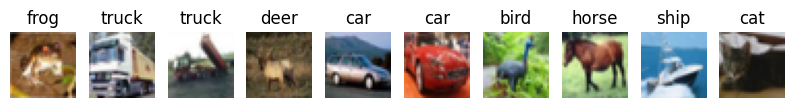

In [3]:
### DATA LOADING ###

train_loader, val_loader = get_CIFAR10_dataset(batch_size=BATCH_SIZE)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_loader.dataset.data[i])
    plt.title(classes[train_loader.dataset.targets[i]])
    plt.axis('off')

## Distribution of Gradient

In [4]:
### MODEL ###

model_meta = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    **META_CONFIG
).to(DEVICE)

num_params = sum(p.numel() for p in model_meta.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 173770


In [5]:
### OTHERS ###

EPOCHS = 1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_meta.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-5)

In [6]:

def train_get_gd(train_loader, model, criterion, optimizer, epoch, epoch_pbar=None, verbose=True):
    gradient_distribution = {}

    model.train()

    num_data = 0
    num_correct = 0
    sum_loss = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False) if verbose else train_loader
    for input, label in pbar:
        input = input.cuda()
        label = label.cuda()

        output = model(input)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        target_grad_0 = model.transformer.layers[0][0].fn.to_qkv.weight.grad
        target_grad_1 = model.transformer.layers[0][0].fn.to_out[0].weight.grad
        target_grad_2 = model.transformer.layers[0][1].fn.net[0].weight.grad
        target_grad_3 = model.transformer.layers[0][1].fn.net[3].weight.grad

        gradient_distribution['0.to_qkv'] = target_grad_0.detach().cpu().numpy()
        gradient_distribution['0.to_out'] = target_grad_1.detach().cpu().numpy()
        gradient_distribution['0.fc1'] = target_grad_2.detach().cpu().numpy()
        gradient_distribution['0.fc2'] = target_grad_3.detach().cpu().numpy()

        return gradient_distribution

        _, predicted = torch.max(output.data, 1)
        num_data += label.size(0)
        num_correct += (predicted == label).sum().item()
        sum_loss += loss.item() * label.size(0)
    
        accuracy = num_correct / num_data
        avg_loss = sum_loss / num_data

        if verbose:
            pbar.set_postfix(train_accuracy=accuracy, train_loss=avg_loss)
        
    accuracy = num_correct / num_data
    avg_loss = sum_loss / num_data


    return accuracy, avg_loss

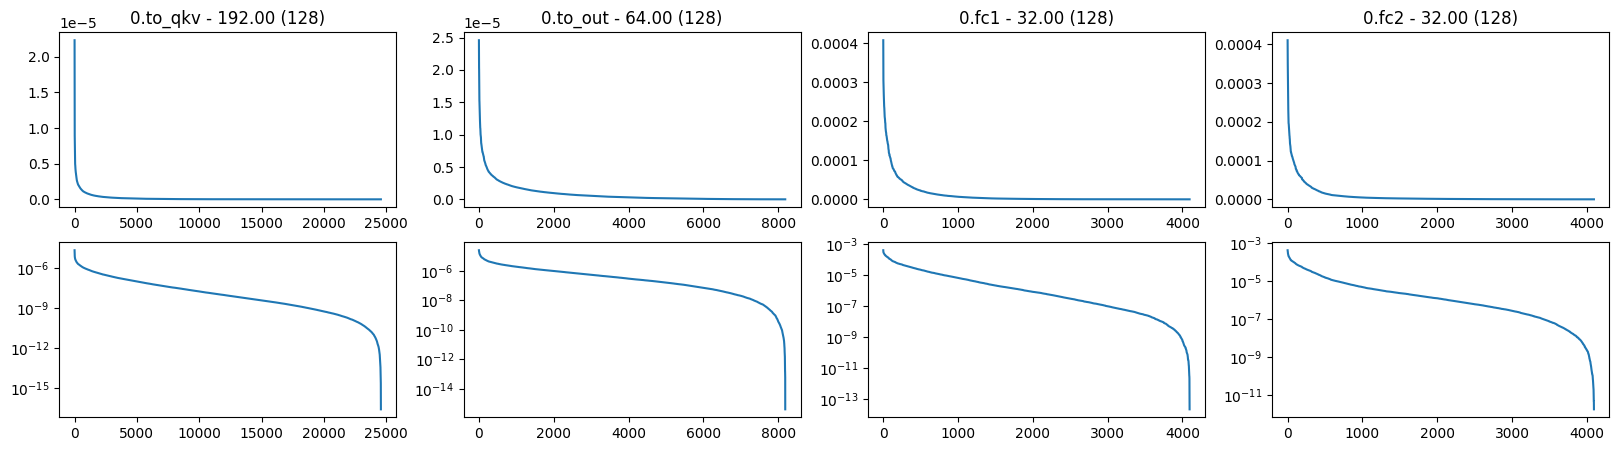

In [7]:
### GET GRADIENT DISTRIBUTION ###

gradient_distribution = train_get_gd(train_loader, model_meta, criterion, optimizer, 0, verbose=False)

### VISUALIZE GRADIENT DISTRIBUTION ###

NUM_QUERY = 128

fig, ax = plt.subplots(2, 4, figsize=(20, 5))

for i, (key, value) in enumerate(gradient_distribution.items()):
    value = value.flatten()
    value = np.power(value, 2)
    value = -np.sort(-value)

    norm = np.sum(value)

    subnorm = 0
    
    now_idx = 0
    dimension = value.shape[0]

    for j in range(NUM_QUERY):
        next_idx = now_idx + dimension // NUM_QUERY
        subnorm += np.sum(value[now_idx:next_idx]) * (next_idx - now_idx)
        now_idx = next_idx
    
    subnorm += np.sum(value[now_idx:]) * (dimension - now_idx)

    ax[0][i].plot(value)
    ax[0][i].set_title(f'{key} - {subnorm / norm:.2f} ({NUM_QUERY})')

    ax[1][i].plot(value)
    ax[1][i].set_yscale('log')

    
plt.show()

Epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1/1 - Train Accuracy: 0.3157, Train Loss: 1.8781, Val Accuracy: 0.4350, Val Loss: 1.5802


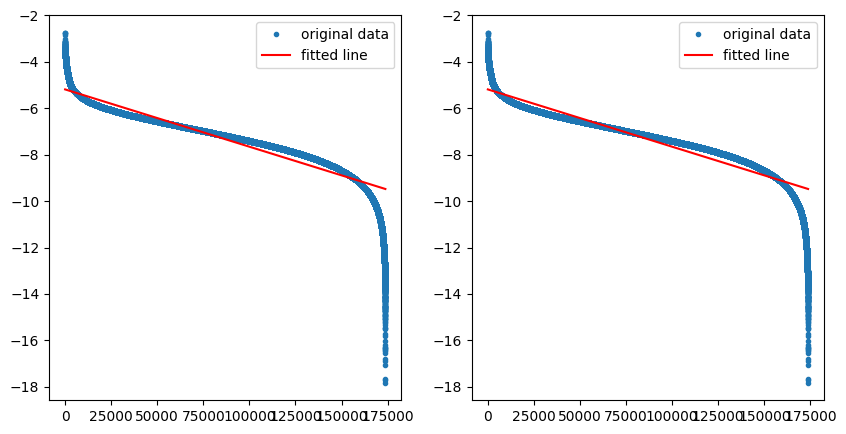

Number of parameters moved: 142785/173770


In [21]:
## OLD GRADIENTS ##

num_params = sum(p.numel() for p in model_meta.parameters() if p.requires_grad)

all_gradients_old = torch.cat([torch.flatten(p.grad) for p in model_meta.parameters() if p.grad is not None])
ranks_old = torch.argsort(all_gradients_old.abs(), descending=True)

partitioned_old = torch.zeros_like(all_gradients_old)
for i in range(10):
    partitioned_old[ranks_old[i * num_params // 10 : (i+1) * num_params // 10]] = i

all_gradients_old = torch.sort(all_gradients_old.abs(), descending=True).values

x_old = np.arange(len(all_gradients_old))
y_old = np.log(all_gradients_old.cpu().numpy())

a_old, B_log_old = np.polyfit(x_old, y_old, 1)

## TRAIN ##

PRETRAIN_EPOCHS = 1

for epoch in range(PRETRAIN_EPOCHS):
    train_acc, train_loss = train(train_loader, model_meta, criterion, optimizer, epoch, verbose=True)
    val_acc, val_loss = validate(val_loader, model_meta, criterion, epoch, verbose=True)

    print(f"Epoch {epoch+1}/{PRETRAIN_EPOCHS} - Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


## NEW GRADIENTS ##

all_gradients_new = torch.cat([torch.flatten(p.grad) for p in model_meta.parameters() if p.grad is not None])
ranks_new = torch.argsort(all_gradients_new.abs(), descending=True)

partitioned_new = torch.zeros_like(all_gradients_new)
for i in range(10):
    partitioned_new[ranks_new[i * num_params // 10 : (i+1) * num_params // 10]] = i

all_gradients_new = torch.sort(all_gradients_new.abs(), descending=True).values

x_new = np.arange(len(all_gradients_new))
y_new = np.log(all_gradients_new.cpu().numpy())

a_new, B_log_new = np.polyfit(x_new, y_new, 1)

# plot the data and the fitted line
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax1.plot(x_old, y_old, '.', label='original data')
ax1.plot(x_old, a_old*x_old + B_log_old, 'r', label='fitted line')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(x_old, y_old, '.', label='original data')
ax2.plot(x_old, a_old*x_old + B_log_old, 'r', label='fitted line')
ax2.legend()

plt.show()

# rank difference
partition_moved = torch.sum(partitioned_old != partitioned_new).item()
print(f"Number of parameters moved: {partition_moved}/{num_params}")


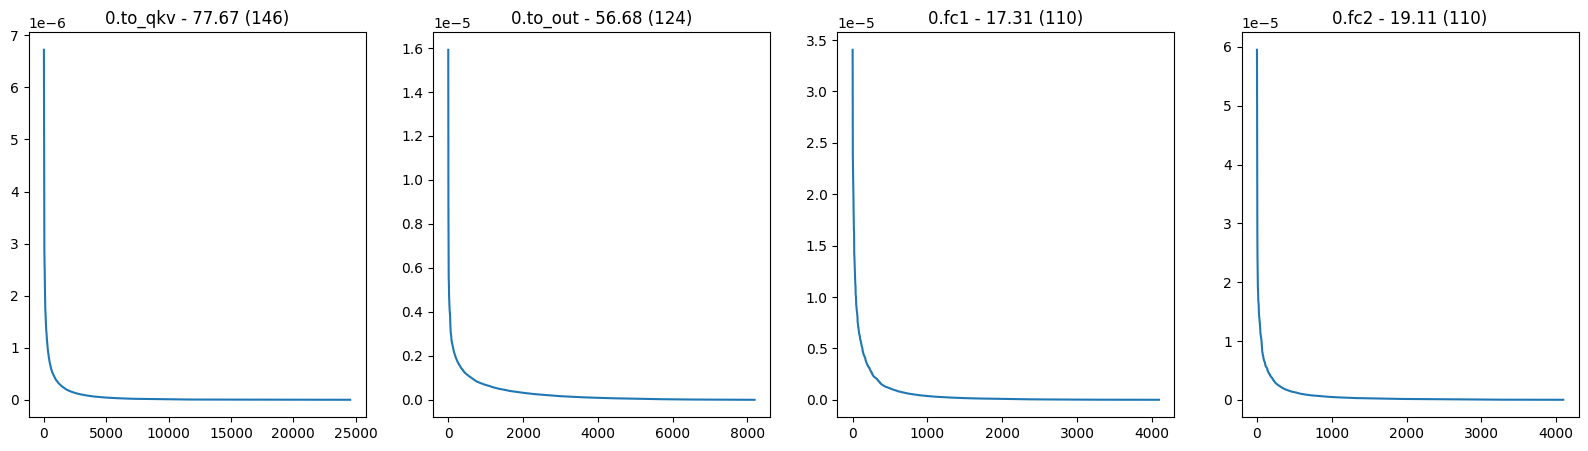

In [9]:
### TRAINING ###

gradient_distribution = train_get_gd(train_loader, model_meta, criterion, optimizer, 0, verbose=False)

### GRADIENT DISTRIBUTION ###

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, (key, value) in enumerate(gradient_distribution.items()):
    value = value.flatten()
    value = np.power(value, 2)
    value = -np.sort(-value)

    norm = np.sum(value)

    subnorm = 0
    
    now_idx = 0
    now_range = 1
    range_expansion = 1.05
    num_query = 0
    dimension = value.shape[0]

    while True:
        num_query += 1
        next_idx = now_idx + int(now_range)
        subnorm += np.sum(value[now_idx:min(next_idx, dimension)]) * int(now_range)

        now_idx = next_idx

        if next_idx >= dimension:
            break

        now_range *= range_expansion
    

    ax[i].plot(value)
    ax[i].set_title(f'{key} - {subnorm / norm:.2f} ({num_query})')
    
plt.show()

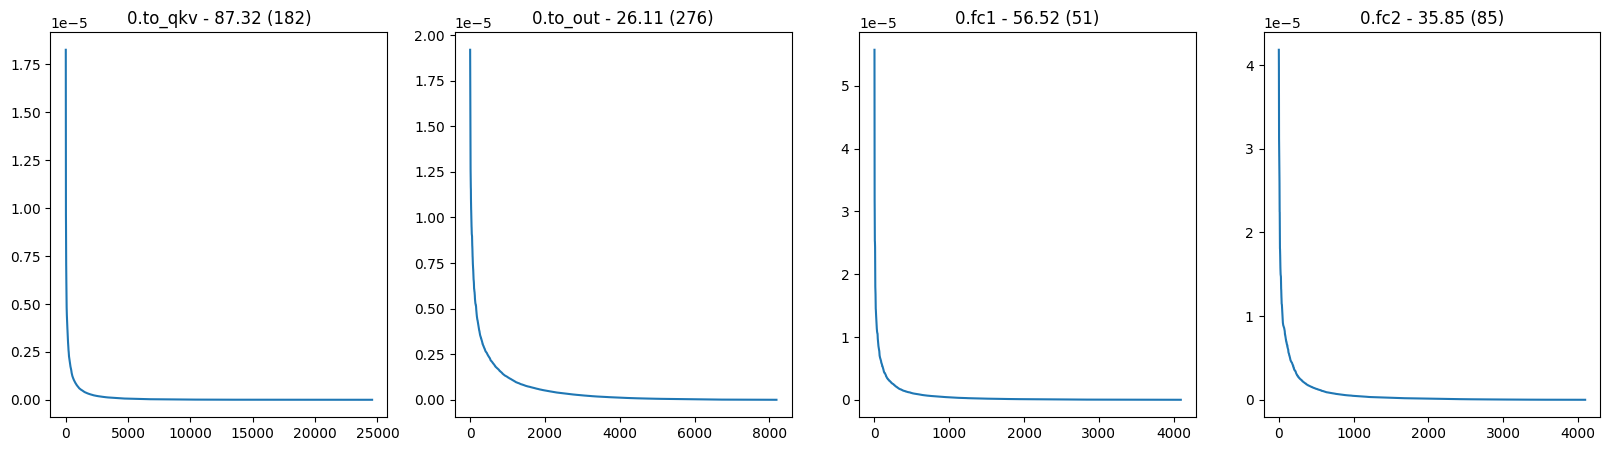

In [10]:
### TRAINING ###

gradient_distribution = train_get_gd(train_loader, model_meta, criterion, optimizer, 0, verbose=False)

### GRADIENT DISTRIBUTION ###

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, (key, value) in enumerate(gradient_distribution.items()):
    value = value.flatten()
    value = np.power(value, 2)
    value = -np.sort(-value)

    norm = np.sum(value)

    subnorm = 0
    
    dimension = value.shape[0]
    now_group_start = 0
    now_group_cost = 0
    now_idx = 0

    max_gradient = np.max(value)
    threshold = 1 * max_gradient

    num_query = 0

    while True:
        if now_group_cost + value[now_idx] <= threshold:
            now_group_cost += value[now_idx]
            now_idx += 1
        elif now_group_cost + value[now_idx] > threshold:
            subnorm += now_group_cost * (now_idx - now_group_start)
            now_group_start = now_idx
            now_group_cost = 0
            num_query += 1
        
        if now_idx >= dimension:
            break
    

    ax[i].plot(value)
    ax[i].set_title(f'{key} - {subnorm / norm:.2f} ({num_query})')
    
plt.show()

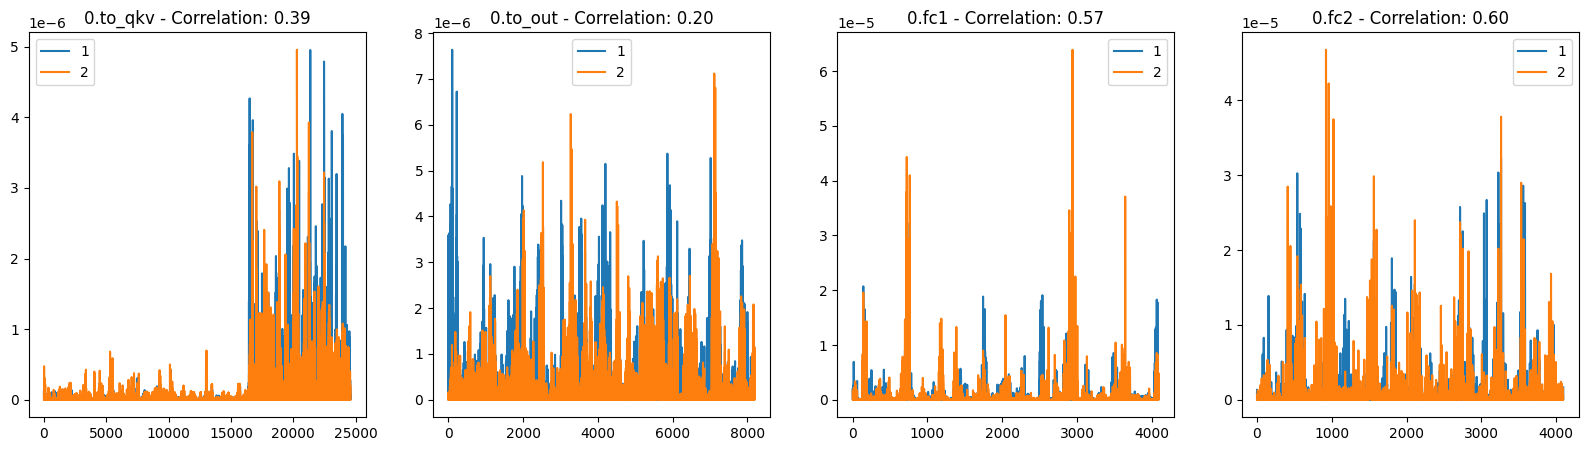

In [11]:
### TRAINING ###

gradient_distribution1 = train_get_gd(train_loader, model_meta, criterion, optimizer, 0, verbose=False)

gradient_distribution2 = train_get_gd(train_loader, model_meta, criterion, optimizer, 0, verbose=False)


### GRADIENT DISTRIBUTION ###

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, (key, value1) in enumerate(gradient_distribution1.items()):
    value1 = value1.flatten()
    value1 = np.power(value1, 2)

    value2 = gradient_distribution2[key].flatten()
    value2 = np.power(value2, 2)

    correlation = np.corrcoef(value1, value2)[0, 1]

    ax[i].plot(value1, label='1')
    ax[i].plot(value2, label='2')
    ax[i].set_title(f'{key} - Correlation: {correlation:.2f}')
    ax[i].legend()
    
plt.show()